In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
G = nx.Graph()

# Dictionary including city names and corresponding numbers
city_dic = {"Norden": 1, "Bremen": 2, "Hamburg": 3, "Hannover": 4, "Berlin": 5, "Leipzig": 6, "Nurnberg": 7, "Munich": 8, "Ulm": 9, "Stuttgart": 10, "Karlsruhe": 11, "Mannheim": 12, "Frankfurt": 13, "Koln": 14, "Dusseldorf": 15, "Essen": 16, "Dortmund": 17}

1

In [127]:
G_num = nx.Graph() # Graph with city numbers
G_name = nx.Graph() # Graph with city names

distance_factor = 2 # Given parameter

# Populate the graph with nodes
for i in city_dic:
    val = city_dic[i]
    G_num.add_node(val)
    G_name.add_node(i)

# Remove group specific node (Mannheim)
G_num.remove_node(12)
G_name.remove_node("Mannheim") 

# Original links from the website
# Tuples include: (source, destination, distance, capacity)
links = [("Munich", "Ulm",120,1), ("Munich", "Nurnberg",150,1), ("Ulm", "Stuttgart",70,1), ("Stuttgart", "Nurnberg",160,1), 
         ("Stuttgart", "Karlsruhe",60,1), ("Karlsruhe", "Mannheim",55,1), ("Mannheim", "Frankfurt",70,1), 
         ("Frankfurt", "Nurnberg",190,1), ("Nurnberg", "Leipzig",230,1), ("Frankfurt", "Leipzig",300,1), ("Frankfurt", "Hannover",265,1),
         ("Frankfurt", "Koln",155,1), ("Koln", "Dusseldorf",35,1), ("Koln", "Dortmund",75,1), ("Dusseldorf", "Essen",30,1),
         ("Essen", "Dortmund",30,1), ("Dortmund", "Hannover",185,1), ("Dortmund", "Norden",230,1), ("Norden", "Bremen",120,1),
         ("Bremen", "Hannover",100,1), ("Bremen", "Hamburg",95,1), ("Hamburg", "Berlin",255,1), ("Berlin", "Leipzig",150,1), ("Berlin", "Hannover",250,1),
         ("Leipzig", "Hannover",215,1), ("Hamburg", "Hannover",130,1)]

# Add links from Karlsruhe to Frankfurt to mitigate the absence of Mannheim
links.append(("Karlsruhe", "Frankfurt",125,1))

# Used cities (names)
names = list(G_name.nodes)

# Add edges to the graph
for i_link in links:
    src = i_link[0]
    dst = i_link[1]
    distance = i_link[2] * distance_factor
    capacity = i_link[3]

    if src in names and dst in names:
        G_name.add_edge(src, dst,length=distance, capacity=capacity)
        G_num.add_edge(city_dic[src], city_dic[dst],length=distance, capacity=capacity)
    else:
        print("City/cities not found:", i_link)

City/cities not found: ('Karlsruhe', 'Mannheim', 55, 1)
City/cities not found: ('Mannheim', 'Frankfurt', 70, 1)


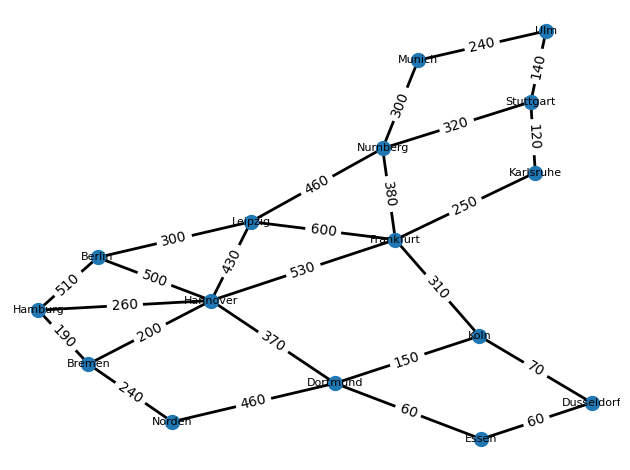

In [129]:
# DRAWING of the graph with city names

# Realistic city positions
#  
# POS = {
#     "Norden": (7.2, 53.6), "Bremen": (8.8, 53.1), "Hamburg": (10.0, 53.5),
#     "Hannover": (9.7, 52.4), "Berlin": (13.4, 52.5), "Leipzig": (12.4, 51.3),
#     "Nurnberg": (11.1, 49.5), "Munich": (11.6, 48.1), "Ulm": (10.0, 48.4),
#     "Stuttgart": (9.2, 48.8), "Karlsruhe": (8.4, 49.0), "Mannheim": (8.5, 49.5),
#     "Frankfurt": (8.7, 50.1), "Koln": (7.0, 51.0), "Dusseldorf": (6.8, 51.2),
#     "Essen": (7.0, 51.45), "Dortmund": (7.5, 51.5)
# }

# pos = {city: POS[city] for city in G_name.nodes()}
pos = nx.spring_layout(G_name, seed=10)

# nodes
nx.draw_networkx_nodes(G_name, pos, node_size=100)

# edges
nx.draw_networkx_edges(G_name, pos, edgelist=G_name.edges, width=2)

# node labels
nx.draw_networkx_labels(G_name, pos, font_size=8, font_family="sans-serif")

# edge labels
edge_lengths = nx.get_edge_attributes(G_name, "length") # Edge weights/lengths AKA the direct path distances between cities
edge_capacities = nx.get_edge_attributes(G_name, "capacity") # Capacities of the links
edge_labels = {} # Combination of lenghts and capacities 

for i, key in enumerate(edge_lengths):
    length = edge_lengths[key]
    capacity = edge_capacities[key]
    edge_labels[key] = "l: " + str(length) + ", c: " + str(capacity)

nx.draw_networkx_edge_labels(G_name, pos, edge_lengths) 

ax = plt.gca()
ax.margins(0.00115)
plt.axis("off")
plt.tight_layout()
plt.show()

In [130]:
print("#Edges:", G_name.number_of_edges(), "#Nodes:", G_name.number_of_nodes())

#Edges: 25 #Nodes: 16


Max: 6
Min: 2
Avg: 3.125
Var: 1.359375


<BarContainer object of 5 artists>

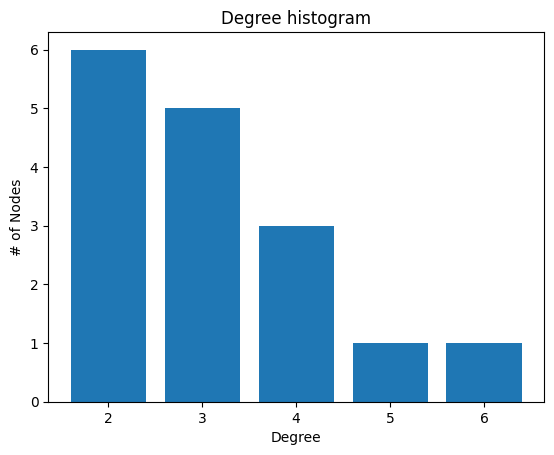

In [131]:
# DEGREE TASKS
degree_sequence = sorted((d for n, d in G_name.degree()), reverse=True)

# max, min, avg, variance
dmax = max(degree_sequence)
dmin = min(degree_sequence)
avg = np.average(degree_sequence)
var = np.var(degree_sequence)

print("Max:", dmax)
print("Min:", dmin)
print("Avg:", avg)
print("Var:", var)

# Distribution of degrees
distr = np.unique(degree_sequence, return_counts=True)

# Histogram
plt.title("Degree histogram")
plt.xlabel("Degree")
plt.ylabel("# of Nodes")
plt.bar(*distr)